In [ ]:
import sionna as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import Model
from tensorflow.keras.layers  import Dense
import numpy as np
import pickle
from scipy.special import erfc
from sionna.utils import sim_ber
import utils
from utils.my_utils import load_weights
import sys
sys.path.append('..')
from config import WEIGHTS_PATH

In [ ]:
#Initialized parameters
EBN0_DB_MIN = 0
EBN0_DB_MAX = 20.0

BATCH_SIZE = 128 
NUM_BITS_PER_SYMBOL = 4 
M = 2**NUM_BITS_PER_SYMBOL

weights_path = WEIGHTS_PATH

### DNN Demapper

In [ ]:
# Define the NeuralDemapper model
class NeuralDemapper(Model):
    def __init__(self):
        super(NeuralDemapper, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.dense_3 = Dense(NUM_BITS_PER_SYMBOL, activation=None)

    def call(self, y):
        # Separate real and imaginary parts and stack them
        nn_input = tf.stack([tf.math.real(y), tf.math.imag(y)], axis=-1)
        # Pass through Dense layers
        z = self.dense_1(nn_input)
        z = self.dense_2(z)
        z = self.dense_3(z)
        # Reshape the output
        llr_DNN = tf.reshape(z, [tf.shape(y)[0], -1]) 
        return llr_DNN


### E2E system using DNN-Demapper

In [6]:
class End2EndSystem_DNN(Model):
  def __init__(self,training_status):
    super().__init__()

    self.binary_source = sn.utils.BinarySource()
    self.constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL, trainable = True)
    self.mapper = sn.mapping.Mapper(constellation=self.constellation)
    self.demapper_DNN = NeuralDemapper()
    
    self.awgn_channel = sn.channel.AWGN()
    self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    self.training_status = training_status
    
  def  __call__(self, batch_size, ebno_db):
    no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=1.0)

    tx_bits_DNN = self.binary_source([batch_size, 1200])
    x = self.mapper(tx_bits_DNN)
    y = self.awgn_channel([x, no])
    llr_DNN = self.demapper_DNN(y)
    if self.training_status:
      loss = self.bce(tx_bits_DNN, llr_DNN)
      return loss
    else:
      return tx_bits_DNN, llr_DNN

### Training Effect of Eb/No Performance: NN-based Demapper

In [7]:
ebno_dbs_eval = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX, 20)

In [8]:
NUM_BITS_PER_SYMBOL = 4

In [9]:
model_weights_DNN_16QAM_4 = weights_path + f'/weights of NeuralDemapperDNN_16QAM_4dB'
model_DNN_16QAM_4 = End2EndSystem_DNN(False)
load_weights(model_DNN_16QAM_4, model_weights_DNN_16QAM_4)
ber_DNN_16QAM_4,_ = sim_ber(model_DNN_16QAM_4, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4048e-01 | 1.0000e+00 |       21577 |      153600 |          128 |         128 |         0.4 |reached target block errors
    1.053 | 1.1563e-01 | 1.0000e+00 |       17761 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 9.5495e-02 | 1.0000e+00 |       14668 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 7.3320e-02 | 1.0000e+00 |       11262 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 5.6022e-02 | 1.0000e+00 |        8605 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 3.6719e-02 | 1.0000e+00 |        5640 |      153600 

In [10]:
model_weights_DNN_16QAM_8 = weights_path + f'/weights of NeuralDemapperDNN_16QAM_8dB'
model_DNN_16QAM_8 = End2EndSystem_DNN(False)
load_weights(model_DNN_16QAM_8, model_weights_DNN_16QAM_8)
ber_DNN_16QAM_8,_ = sim_ber(model_DNN_16QAM_8, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4092e-01 | 1.0000e+00 |       21645 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.1945e-01 | 1.0000e+00 |       18347 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 9.5384e-02 | 1.0000e+00 |       14651 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 7.3132e-02 | 1.0000e+00 |       11233 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 5.5137e-02 | 1.0000e+00 |        8469 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 3.7493e-02 | 1.0000e+00 |        5759 |      153600 |

In [11]:
model_weights_DNN_16QAM_12 = weights_path + f'/weights of NeuralDemapperDNN_16QAM_12dB'
model_DNN_16QAM_12 = End2EndSystem_DNN(False)
load_weights(model_DNN_16QAM_12, model_weights_DNN_16QAM_12)
ber_DNN_16QAM_12,_ = sim_ber(model_DNN_16QAM_12, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4135e-01 | 1.0000e+00 |       21712 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.1768e-01 | 1.0000e+00 |       18075 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 9.6628e-02 | 1.0000e+00 |       14842 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 7.4883e-02 | 1.0000e+00 |       11502 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 5.4512e-02 | 1.0000e+00 |        8373 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 3.7604e-02 | 1.0000e+00 |        5776 |      153600 |

In [12]:
NUM_BITS_PER_SYMBOL = 6

In [13]:
model_weights_DNN_64QAM_4 = weights_path + f'/weights of NeuralDemapperDNN_64QAM_4dB'
model_DNN_64QAM_4 = End2EndSystem_DNN(False)
load_weights(model_DNN_64QAM_4, model_weights_DNN_64QAM_4)
ber_DNN_64QAM_4,_ = sim_ber(model_DNN_64QAM_4, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9505e-01 | 1.0000e+00 |       29959 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.7080e-01 | 1.0000e+00 |       26235 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 1.5139e-01 | 1.0000e+00 |       23254 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.3099e-01 | 1.0000e+00 |       20120 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.1265e-01 | 1.0000e+00 |       17303 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 9.5677e-02 | 1.0000e+00 |       14696 |      153600 |

In [14]:
model_weights_DNN_64QAM_8 = weights_path + f'/weights of NeuralDemapperDNN_64QAM_8dB'
model_DNN_64QAM_8 = End2EndSystem_DNN(False)
load_weights(model_DNN_64QAM_8, model_weights_DNN_64QAM_8)
ber_DNN_64QAM_8,_ = sim_ber(model_DNN_64QAM_8, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.9740e-01 | 1.0000e+00 |       30320 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.7371e-01 | 1.0000e+00 |       26682 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 1.5148e-01 | 1.0000e+00 |       23267 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.2873e-01 | 1.0000e+00 |       19773 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.1091e-01 | 1.0000e+00 |       17036 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 9.3633e-02 | 1.0000e+00 |       14382 |      153600 |

In [15]:
model_weights_DNN_64QAM_12 = weights_path + f'/weights of NeuralDemapperDNN_64QAM_12dB'
model_DNN_64QAM_12 = End2EndSystem_DNN(False)
load_weights(model_DNN_64QAM_12, model_weights_DNN_64QAM_12)
ber_DNN_64QAM_12,_ = sim_ber(model_DNN_64QAM_12, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.0005e-01 | 1.0000e+00 |       30727 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 1.7323e-01 | 1.0000e+00 |       26608 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 1.5326e-01 | 1.0000e+00 |       23540 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.3118e-01 | 1.0000e+00 |       20149 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.1181e-01 | 1.0000e+00 |       17174 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 9.2852e-02 | 1.0000e+00 |       14262 |      153600 |

In [16]:
NUM_BITS_PER_SYMBOL = 8

In [17]:
model_weights_DNN_256QAM_4 = weights_path + f'/weights of NeuralDemapperDNN_256QAM_4dB'
model_DNN_256QAM_4 = End2EndSystem_DNN(False)
load_weights(model_DNN_256QAM_4, model_weights_DNN_256QAM_4)
ber_DNN_256QAM_4,_ = sim_ber(model_DNN_256QAM_4, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4318e-01 | 1.0000e+00 |       37352 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 2.2375e-01 | 1.0000e+00 |       34368 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 2.0656e-01 | 1.0000e+00 |       31728 |      153600 |          128 |         128 |         0.0 |reached target block errors
    3.158 | 1.8816e-01 | 1.0000e+00 |       28901 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.7289e-01 | 1.0000e+00 |       26556 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 1.5846e-01 | 1.0000e+00 |       24339 |      153600 |

In [18]:
model_weights_DNN_256QAM_8 = weights_path + f'/weights of NeuralDemapperDNN_256QAM_8dB'
model_DNN_256QAM_8 = End2EndSystem_DNN(False)
load_weights(model_DNN_256QAM_8, model_weights_DNN_256QAM_8)
ber_DNN_256QAM_8,_ = sim_ber(model_DNN_256QAM_8, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4268e-01 | 1.0000e+00 |       37276 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 2.2355e-01 | 1.0000e+00 |       34338 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 2.0374e-01 | 1.0000e+00 |       31294 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.8516e-01 | 1.0000e+00 |       28440 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.6733e-01 | 1.0000e+00 |       25702 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 1.5123e-01 | 1.0000e+00 |       23229 |      153600 |

In [19]:
model_weights_DNN_256QAM_12 = weights_path + f'/weights of NeuralDemapperDNN_256QAM_12dB'
model_DNN_256QAM_12 = End2EndSystem_DNN(False)
load_weights(model_DNN_256QAM_12, model_weights_DNN_256QAM_12)
ber_DNN_256QAM_12,_ = sim_ber(model_DNN_256QAM_12, ebno_dbs_eval, batch_size=128, num_target_block_errors=100, max_mc_iter=100, soft_estimates=True)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.4740e-01 | 1.0000e+00 |       38001 |      153600 |          128 |         128 |         0.1 |reached target block errors
    1.053 | 2.2602e-01 | 1.0000e+00 |       34716 |      153600 |          128 |         128 |         0.1 |reached target block errors
    2.105 | 2.0774e-01 | 1.0000e+00 |       31909 |      153600 |          128 |         128 |         0.1 |reached target block errors
    3.158 | 1.8655e-01 | 1.0000e+00 |       28654 |      153600 |          128 |         128 |         0.1 |reached target block errors
    4.211 | 1.6701e-01 | 1.0000e+00 |       25652 |      153600 |          128 |         128 |         0.1 |reached target block errors
    5.263 | 1.4672e-01 | 1.0000e+00 |       22536 |      153600 |

### Plot out

In [ ]:
new_blue = '#36A2EB'     # Vibrant medium blue
new_green = '#2ECC71'    # Bright emerald green
new_orange = '#E67E22'   # Warm orange

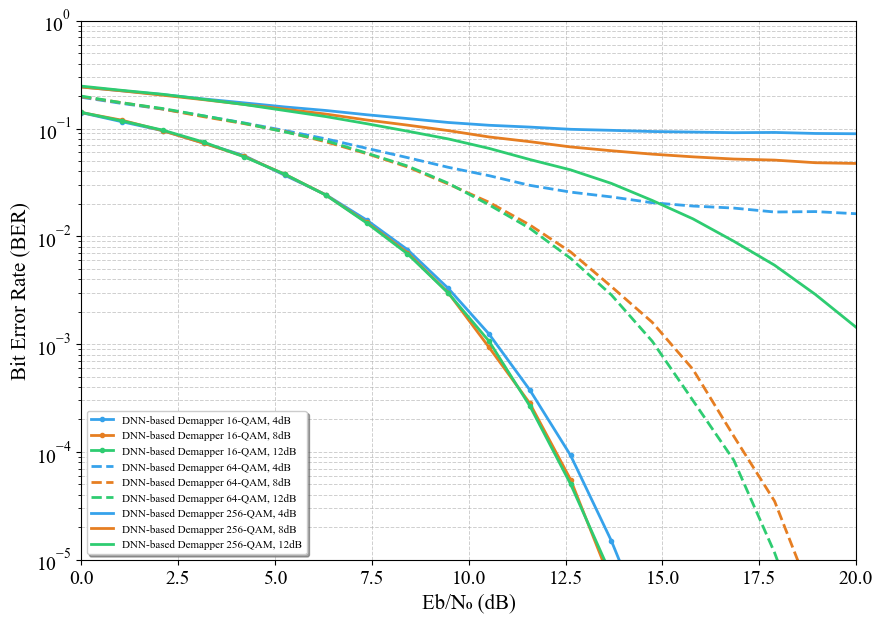

In [ ]:
NUM_BITS_PER_SYMBOL = 4 
eb_no_db_range = np.linspace(0, 20, 20)
# plt.figure(figsize=(8, 6))
plt.figure(figsize=(10, 7))
mpl.rcParams['font.family'] = 'serif'  # or 'sans-serif', 'monospace', etc.
mpl.rcParams['font.serif'] = ['Times New Roman']  # or any available font on your system
mpl.rcParams['font.size'] = 14  # Increase this for larger text
plt.semilogy(eb_no_db_range, ber_DNN_16QAM_4, 'o-',color = new_blue, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**NUM_BITS_PER_SYMBOL}-QAM, 4dB')
plt.semilogy(eb_no_db_range, ber_DNN_16QAM_8, 'o-',color = new_orange, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**NUM_BITS_PER_SYMBOL}-QAM, 8dB')
plt.semilogy(eb_no_db_range, ber_DNN_16QAM_12, 'o-',color = new_green, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**NUM_BITS_PER_SYMBOL}-QAM, 12dB')
plt.semilogy(eb_no_db_range, ber_DNN_64QAM_4, '--',color = new_blue, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+2)}-QAM, 4dB')
plt.semilogy(eb_no_db_range, ber_DNN_64QAM_8, '--',color = new_orange, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+2)}-QAM, 8dB')
plt.semilogy(eb_no_db_range, ber_DNN_64QAM_12, '--',color = new_green, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+2)}-QAM, 12dB')
plt.semilogy(eb_no_db_range, ber_DNN_256QAM_4, '-',color = new_blue, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+4)}-QAM, 4dB')
plt.semilogy(eb_no_db_range, ber_DNN_256QAM_8, '-',color = new_orange, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+4)}-QAM, 8dB')
plt.semilogy(eb_no_db_range, ber_DNN_256QAM_12, '-',color = new_green, markersize=3, linewidth=2, label=f'DNN-based Demapper {2**(NUM_BITS_PER_SYMBOL+4)}-QAM, 12dB')

plt.xlabel('Eb/N₀ (dB)', fontsize=15)
plt.ylabel('Bit Error Rate (BER)', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Legend styling
plt.legend(loc='lower left', fontsize=8, frameon=True, shadow=True, fancybox=True)

plt.ylim(1e-5, 1)
plt.xlim(0,20)

# Ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.legend()

plt.show()